In [1]:
#Adding the libraries
import tensorflow as tf
import numpy as np
import os
import pandas as pd

In [2]:
#diresctory of the train and test dataset
train_dir = r"train"
test_dir = r"test"
os.path.exists(test_dir)

True

In [3]:
#reading the dataset which have all labels of all images
df = pd.read_csv('Training_set.csv')
df.shape

(6499, 2)

In [4]:
all_images_label = df['label'].unique()
all_images_label

<StringArray>
[         'SOUTHERN DOGFACE',                    'ADONIS',
            'BROWN SIPROETA',                   'MONARCH',
  'GREEN CELLED CATTLEHEART',           'CAIRNS BIRDWING',
      'EASTERN DAPPLE WHITE',               'RED POSTMAN',
          'MANGROVE SKIPPER',          'BLACK HAIRSTREAK',
             'CABBAGE WHITE',               'RED ADMIRAL',
              'PAINTED LADY',                'PAPER KITE',
                 'SOOTYWING',                'PINE WHITE',
                   'PEACOCK',        'CHECQUERED SKIPPER',
                     'JULIA',         'COMMON WOOD-NYMPH',
               'BLUE MORPHO',           'CLOUDED SULPHUR',
            'STRAITED QUEEN',            'ORANGE OAKLEAF',
           'PURPLISH COPPER',                     'ATALA',
           'IPHICLUS SISTER',             'DANAID EGGFLY',
              'LARGE MARBLE',          'PIPEVINE SWALLOW',
         'BLUE SPOTTED CROW',               'RED CRACKER',
             'QUESTION MARK',             

In [5]:
import shutil
def move_images(species):
    for images in df.loc[df['label'] == species, 'filename']:
        shutil.move(os.path.join(train_dir, images), os.path.join(os.path.join(train_v2_dir, species), images))

In [6]:
#for labels in uniq:
#    move_images(labels)

In [7]:
# from tensorflow.keras import mixed_precision
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_global_policy(policy)

In [8]:
#prepare the dataset

train_v2_dir = r"train_v2"
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=train_v2_dir,
    labels='inferred',
    validation_split=0.2,
    subset='training',
    batch_size=32,
    shuffle=True,
    color_mode='rgb',
    seed=123,
    image_size = (128,128)
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=train_v2_dir,
    labels='inferred',
    validation_split=0.2,
    subset='validation',
    batch_size=32,
    shuffle=True,
    color_mode='rgb',
    seed=123,
    image_size = (128,128)
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=test_dir,
    labels=None,
    batch_size=32,
    shuffle=True,
    color_mode='rgb',
    image_size = (128,128)
)

Found 6499 files belonging to 75 classes.
Using 5200 files for training.
Found 6499 files belonging to 75 classes.
Using 1299 files for validation.
Found 2786 files.


In [9]:
#preprocessing the dataset
train_ds_final = (train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE))
val_ds_final = (val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE))
test_ds_final = (test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE))

In [10]:
#data augmentation and rescaling
aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomTranslation(0.2,0.2)
])
rescale_input = tf.keras.Sequential([
    tf.keras.layers.Resizing(100,100),
    tf.keras.layers.Rescaling(1./255)
])

In [11]:
#model deployment
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(128,128,3)),
    rescale_input,
    aug,
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    # tf.keras.layers.MaxPooling2D((2, 2)),
    # tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
    # tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    # tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(256, activation='relu'),
    # tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation='relu'),
    # tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(75,activation='softmax')
])

In [12]:
#custom optimizer
adam = tf.keras.optimizers.Adam(learning_rate=0.0001,epsilon=1e-07)

In [13]:
model.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=adam, metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 22, 22, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     7,930,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 75)             │         9,675 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,214,027 (31.33 MB)

 Trainable params: 8,214,027 (31.33 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = model.fit(train_ds_final, validation_data=val_ds_final, epochs=100)

Epoch 1/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 152ms/step - accuracy: 0.4463 - loss: 1.9354 - val_accuracy: 0.3849 - val_loss: 2.3346
Epoch 2/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 197ms/step - accuracy: 0.4456 - loss: 1.9203 - val_accuracy: 0.3326 - val_loss: 2.6768
Epoch 3/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 37s 228ms/step - accuracy: 0.4640 - loss: 1.8759 - val_accuracy: 0.3741 - val_loss: 2.4198
Epoch 4/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 33s 205ms/step - accuracy: 0.4615 - loss: 1.8747 - val_accuracy: 0.3310 - val_loss: 2.6888
Epoch 5/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 29s 180ms/step - accuracy: 0.4663 - loss: 1.8620 - val_accuracy: 0.3803 - val_loss: 2.4860
Epoch 6/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 34s 208ms/step - accuracy: 0.4787 - loss: 1.8223 - val_accuracy: 0.3857 - val_loss: 2.4437
Epoch 7/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 36s 218ms/step - accuracy: 0.4771 - loss: 1.8097 - val_accuracy: 0.3018 - val_loss: 3.0289
Epoch 8/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 24s 149ms/step - accuracy: 0.4935 -

Text(0.5, 1.0, 'Training and Validation Accuracy')

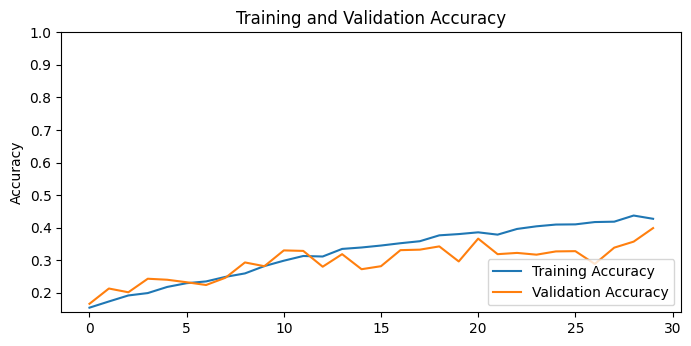

In [45]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')